In [1]:
import scvelo as scv
import dynamo as dyn
import numpy as np
import scanpy as sc
import cellrank as cr
import wandb
import magic
import anndata
from tqdm import tqdm

In [2]:
# adata = sc.read('./adata_hires.h5ad')

In [3]:
adata = cr.datasets.pancreas()

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=20, retain_genes=['Hhex'])
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
magic_operator = magic.MAGIC(t='auto')
adata.layers['Mu'] = magic_operator.fit_transform(adata.layers['Mu'], genes='all_genes')
adata.layers['Ms'] = magic_operator.fit_transform(adata.layers['Ms'], genes='all_genes')

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 20 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Calculating MAGIC...
  Running MAGIC on 2531 cells and 20 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.10 seconds.
    Calculating affinities...


/home/cys/.local/lib/python3.7/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):
/home/cys/.local/lib/python3.7/site-packages/magic/magic.py:382: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  "Running MAGIC on {} cells and {} genes.".format(X.shape[0], X.shape[1])
/home/cys/.local/lib/python3.7/site-packages/magic/magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):


    Calculated affinities in 0.11 seconds.
  Calculated graph and diffusion operator in 0.21 seconds.
  Calculating imputation...
    Automatically selected t = 3
Calculated MAGIC in 0.22 seconds.
Calculating MAGIC...
  Running MAGIC on 2531 cells and 20 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.11 seconds.
    Calculating affinities...


/home/cys/.local/lib/python3.7/site-packages/magic/magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("imputation"):
/home/cys/.local/lib/python3.7/site-packages/magic/magic.py:779: DeprecationWarning: Call to deprecated method debug. (Use TaskLogger.log_debug instead) -- Deprecated since version 1.1.0.
  _logger.debug("{}: {}".format(i, error_vec))
/home/cys/.local/lib/python3.7/site-packages/magic/magic.py:782: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info("Automatically selected t = {}".format(t_opt))
/home/cys/.local/lib/python3.7/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):
/home/cys/.local/lib/python3.7/site-packages/magic/magic.py:382: DeprecationWarn

    Calculated affinities in 0.10 seconds.
  Calculated graph and diffusion operator in 0.22 seconds.
  Calculating imputation...
    Automatically selected t = 3
Calculated MAGIC in 0.23 seconds.


/home/cys/.local/lib/python3.7/site-packages/magic/magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("imputation"):
/home/cys/.local/lib/python3.7/site-packages/magic/magic.py:779: DeprecationWarning: Call to deprecated method debug. (Use TaskLogger.log_debug instead) -- Deprecated since version 1.1.0.
  _logger.debug("{}: {}".format(i, error_vec))
/home/cys/.local/lib/python3.7/site-packages/magic/magic.py:782: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info("Automatically selected t = {}".format(t_opt))


In [5]:
# sc.tl.leiden(adata, resolution=15)

In [6]:
adata

AnnData object with n_obs × n_vars = 2531 × 20
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'connectivities', 'distances'

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np

import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

# The system of ODEs
def ode_system(t, y, alpha, beta, gamma):
    u, s = y
    du_dt = alpha - beta * u
    ds_dt = beta * u - gamma * s
    return [du_dt, ds_dt]

# Objective function to minimize
def objective_function(params, u_data, s_data, t_data):
    residuals = []
    for i in range(u_data.shape[1]):  # Loop over each feature
        alpha, beta, gamma = params[i*3:(i+1)*3]  # Extract parameters for this feature
        y0 = [u_data[0, i], s_data[0, i]]  # Initial conditions for this feature
        solution = solve_ivp(ode_system, [t_data[0], t_data[-1]], y0, args=(alpha, beta, gamma), t_eval=t_data, method='RK45')
        u_model, s_model = solution.y
        residuals.extend(u_data[:, i] - u_model)
        residuals.extend(s_data[:, i] - s_model)
    return residuals

# Function to fit the ODE to the data
def fit_ODE(u_data, s_data, t_data):
    n_features = u_data.shape[1]
    initial_guess = np.tile([1.0, 1.0, 1.0], n_features)  # Initial guesses for each feature
    # Bounds for each parameter for each feature
    lower_bounds = np.tile([0, 0, 0], n_features)
    upper_bounds = np.tile([np.inf, np.inf, np.inf], n_features)
    # Run the optimization with bounds
    result = least_squares(objective_function, initial_guess, args=(u_data, s_data, t_data.flatten()), bounds=(lower_bounds, upper_bounds))
    # Run the optimization
    
    # Reshape the result to have the shape (1, n_features) for alpha, beta, and gamma
    params = result.x.reshape(-1, 3).T  # Transpose to get the correct shape
    alpha, beta, gamma = params[0], params[1], params[2]
    return alpha.reshape(n_features), beta.reshape(n_features), gamma.reshape(n_features)

In [8]:
def coarse_mode(adata, pt_key='palantir_pseudotime', num_epochs=100):
    # Sort adata based on pseudo-time
    pseudo_time = adata.obs[pt_key].values
    sorted_indices = np.argsort(pseudo_time)
    adata = adata[sorted_indices,]
    n_samples = adata.shape[0]
    
    alpha, beta, gamma = fit_ODE(adata.layers['Mu'], adata.layers['Ms'], 
                                 adata.obs[pt_key].values)
    
    alpha = np.repeat(alpha.reshape(1, -1), n_samples, axis=0)
    beta = np.repeat(beta.reshape(1, -1), n_samples, axis=0)
    gamma = np.repeat(gamma.reshape(1, -1), n_samples, axis=0)
    adata.layers['alpha'] = alpha
    adata.layers['beta'] = beta
    adata.layers['gamma'] = gamma
    adata.layers['velocity'] = adata.layers['Mu'] * adata.layers['beta'] - adata.layers['Ms'] * adata.layers['gamma']
    adata.layers['unspliced_velocity'] = adata.layers['alpha'] - adata.layers['Mu'] * adata.layers['beta']
    
    return adata

# Assume coarse_mode function is defined above or imported

# This function will process each group in parallel
def process_group(adata, group, group_value, pt_key='palantir_pseudotime', num_epochs=100):
    adata_i = adata[adata.obs[group] == group_value].copy()
    adata_i = coarse_mode(adata_i, pt_key=pt_key, num_epochs=num_epochs)
    return adata_i

# Modified coarse_grained_kinetics function to use joblib for parallel processing
def coarse_grained_kinetics(adata, group, num_epochs=100, n_jobs=-1):
    group_values = adata.obs[group].value_counts().index

    # Run the processing in parallel
    adata_list = Parallel(n_jobs=n_jobs)(delayed(process_group)(adata, group, group_value, num_epochs=num_epochs) for group_value in tqdm(group_values))
    
    # Concatenate the results
    adata = anndata.concat(adata_list, axis=0)
    
    return adata

# This function will be executed in parallel for each cell
def process_cell(cell_idx, adata, pt_key, num_epochs):
    adj = adata.obsp['connectivities']
    neighbor_indices = adj[cell_idx].nonzero()[1]
    s = adata.layers['Ms'][neighbor_indices, :]
    u = adata.layers['Mu'][neighbor_indices, :]
    t = adata.obs[pt_key][neighbor_indices].values
    
    sorted_indices = np.argsort(t)
    s = s[sorted_indices, ]
    u = u[sorted_indices, ]
    t = t[sorted_indices]
    
    # Assuming fit_neural_ode is a function that you have defined elsewhere
    alpha, beta, gamma = fit_ODE(u, s, t, num_epochs=num_epochs)
    
    return alpha, beta, gamma

# Modified high_resolution_kinetics function to use joblib for parallel processing
def high_resolution_kinetics(adata, pt_key='palantir_pseudotime', num_epochs=100, n_jobs=-1):
    # Initialize matrices
    alpha = np.zeros((adata.shape[0], adata.shape[1]))
    beta = np.zeros((adata.shape[0], adata.shape[1]))
    gamma = np.zeros((adata.shape[0], adata.shape[1]))

    # Run in parallel
    results = Parallel(n_jobs=n_jobs)(delayed(process_cell)(cell_idx, adata, pt_key, num_epochs) for cell_idx in tqdm(range(adata.shape[0])))

    # Unpack results
    for i, (alpha_i, beta_i, gamma_i) in enumerate(results):
        alpha[i,] = alpha_i
        beta[i,] = beta_i
        gamma[i,] = gamma_i

    # Store results in adata
    adata.layers['alpha'] = alpha
    adata.layers['beta'] = beta
    adata.layers['gamma'] = gamma
    adata.layers['velocity'] = adata.layers['Mu'] * beta - adata.layers['Ms'] * gamma
    adata.layers['unspliced_velocity'] = alpha - adata.layers['Mu'] * beta
    return adata

In [9]:
adata = coarse_grained_kinetics(adata, group='clusters', num_epochs=200)

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 730.06it/s]


In [10]:
# adata = high_resolution_kinetics(adata, num_epochs=600)

In [11]:
# adata.write("adata_hires.h5ad")

In [12]:
adata.obs['speed'] = np.linalg.norm(adata.layers['velocity'], ord=2, axis=1)

In [13]:
scv.tl.velocity_graph(adata, n_jobs=-1)
scv.pl.velocity_embedding_stream(adata, basis='umap')

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


ValueError: Your neighbor graph seems to be corrupted. Consider recomputing via pp.neighbors.

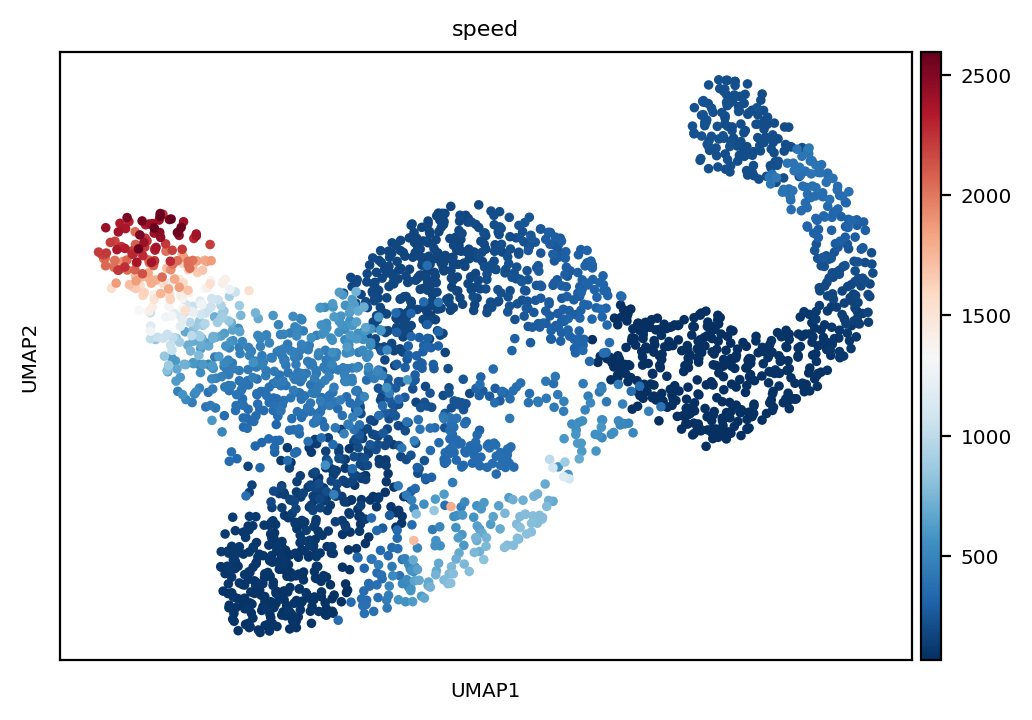

In [21]:
sc.pl.umap(adata, color='speed')

In [17]:
for i in range(adata.shape[1]):
    if adata.var.index[i] == 'Hhex':
        print(i)

9


In [18]:
i = 9

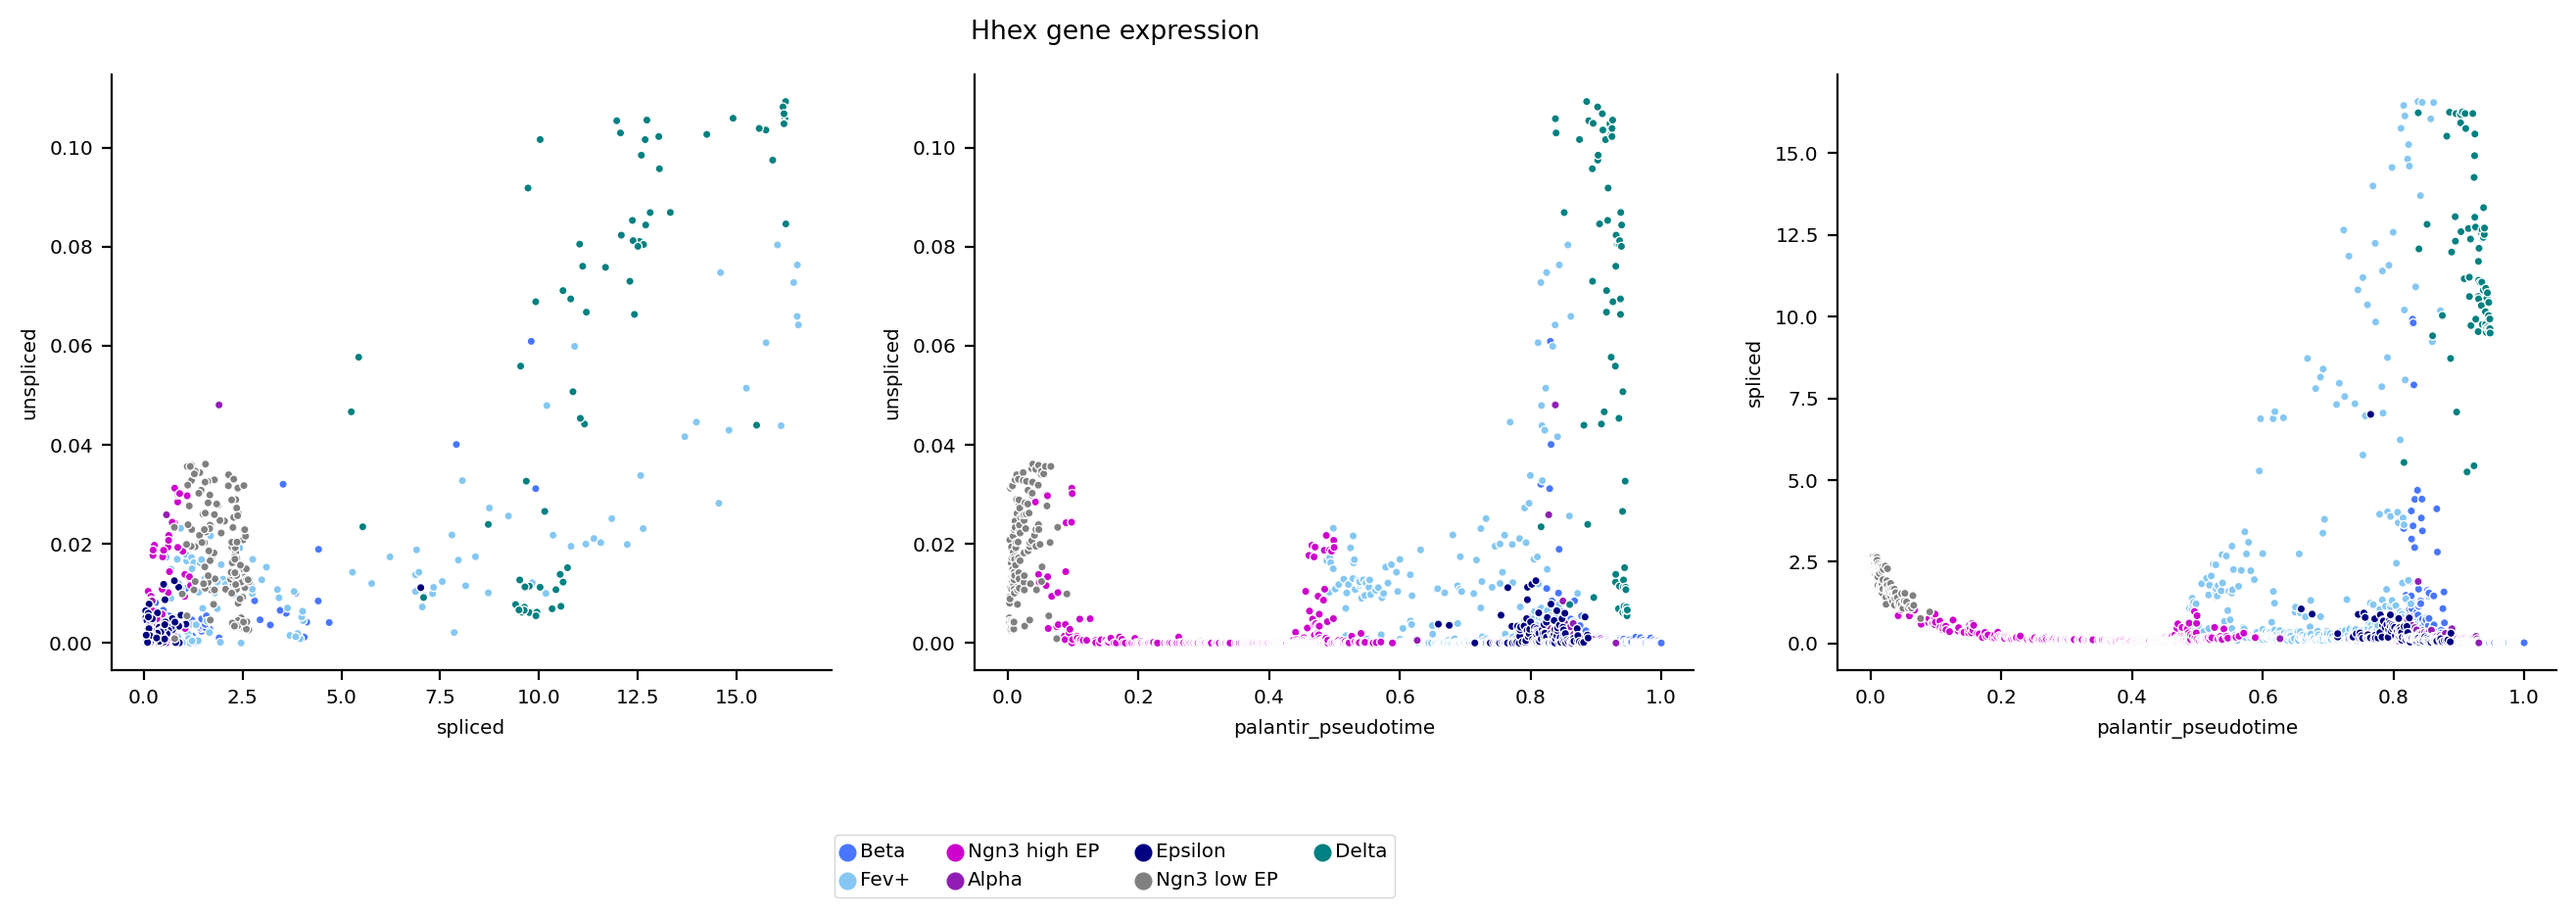

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot 1
sns.scatterplot(x=np.array(adata.layers['Ms'][:, i]).reshape(-1),
                y=np.array(adata.layers['Mu'][:, i]).reshape(-1),
                hue=adata.obs['clusters'], marker='.', ax=axes[0])
axes[0].set_ylabel('unspliced')
axes[0].set_xlabel('spliced')
axes[0].get_legend().remove()

# Plot 2
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=np.array(adata.layers['Mu'][:, i]).reshape(-1),
                hue=adata.obs['clusters'], marker='.', ax=axes[1])
axes[1].set_ylabel('unspliced')
axes[1].set_xlabel('palantir_pseudotime')
axes[1].get_legend().remove()

# Plot 3
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=np.array(adata.layers['Ms'][:, i]).reshape(-1),
                hue=adata.obs['clusters'], marker='.', ax=axes[2])
axes[2].set_ylabel('spliced')
axes[2].set_xlabel('palantir_pseudotime')
axes[2].get_legend().remove()

# Remove top and right spines
for j in range(3):
    axes[j].spines['top'].set_visible(False)
    axes[j].spines['right'].set_visible(False)
handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle(adata.var.iloc[i].name+' gene expression')
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=4)

plt.show()


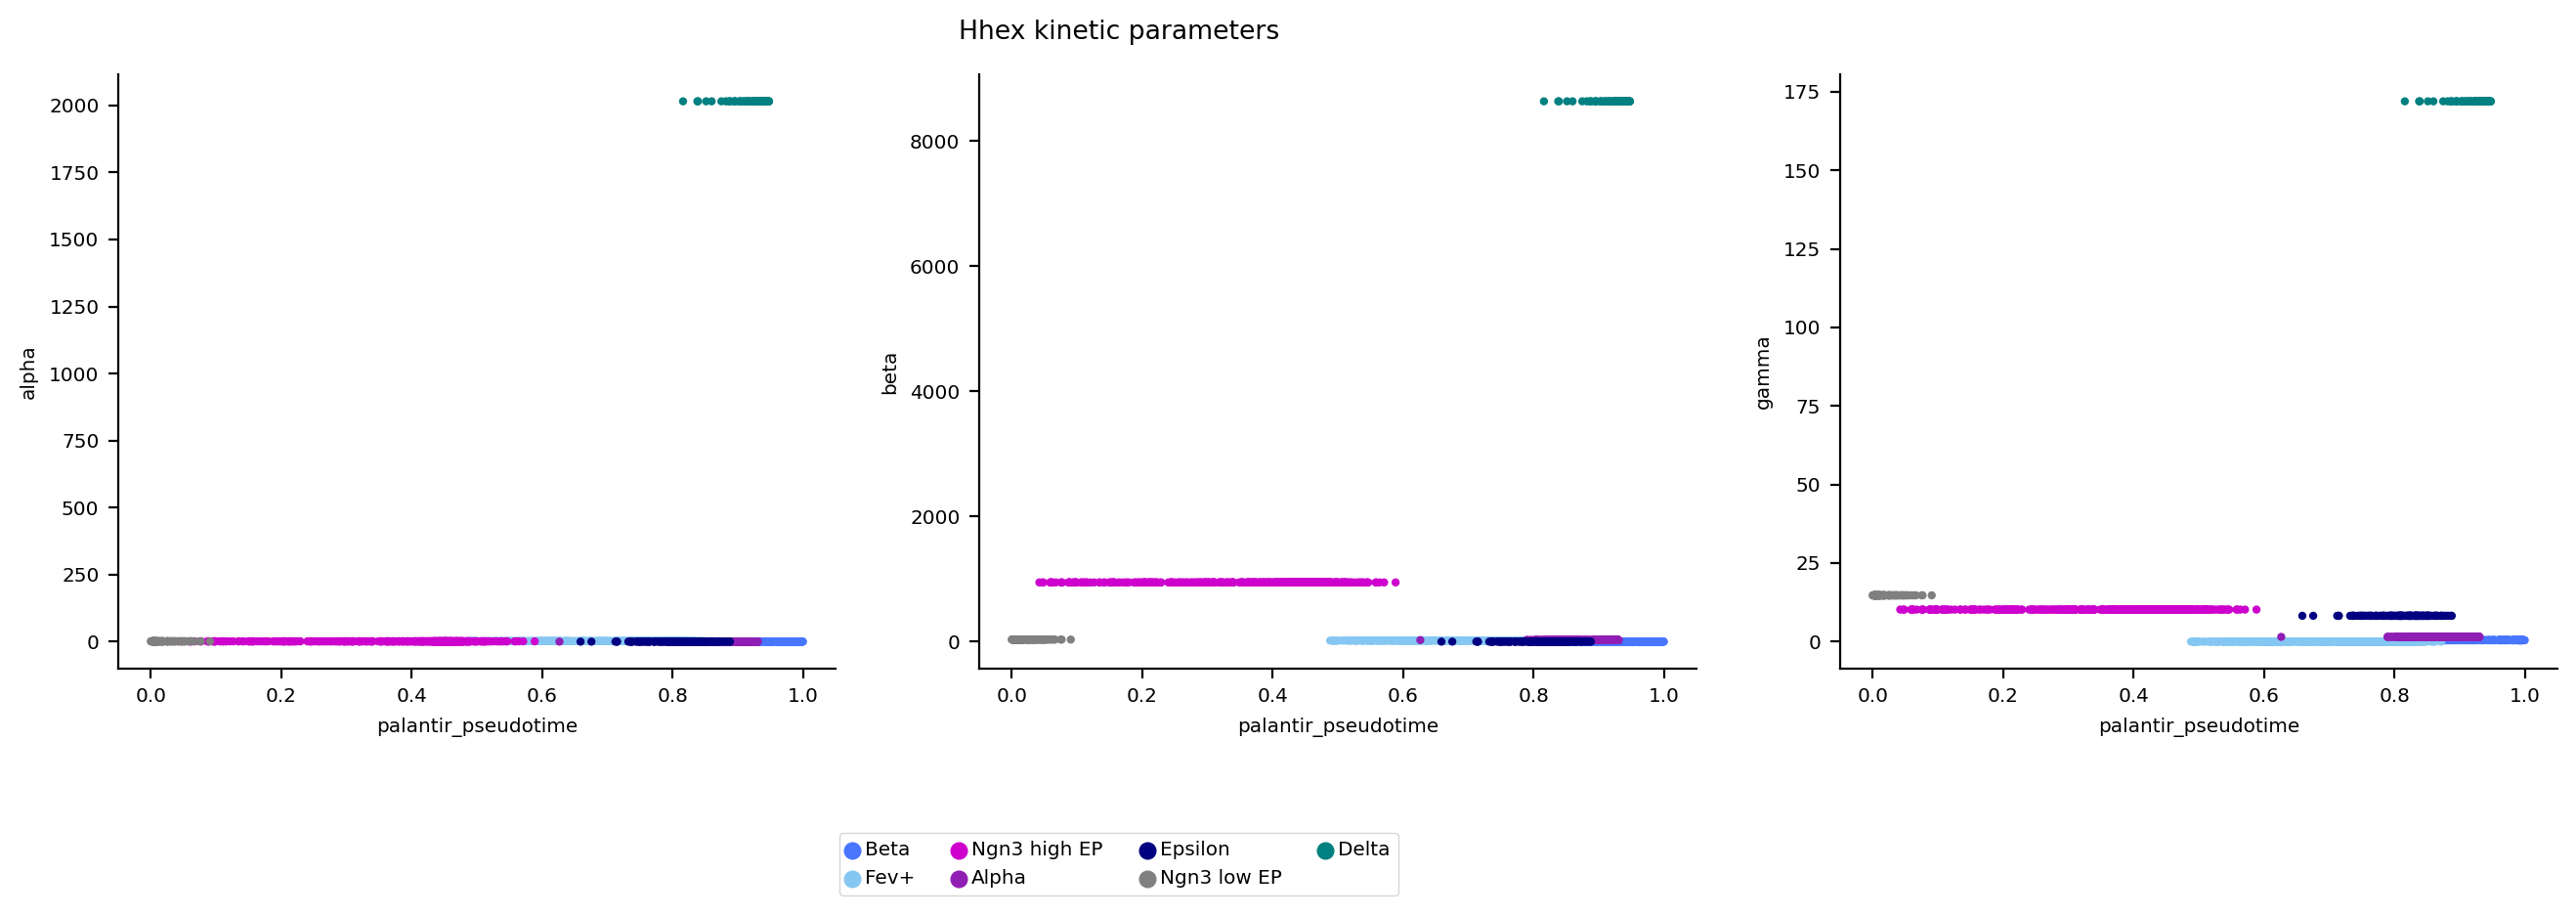

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot 1
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=adata.layers['alpha'][:, i],
                hue=adata.obs['clusters'], marker='.',edgecolor='none', ax=axes[0])
axes[0].set_ylabel('alpha')
axes[0].set_xlabel('palantir_pseudotime')
axes[0].get_legend().remove()

# Plot 2
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=adata.layers['beta'][:, i],
                hue=adata.obs['clusters'], marker='.',edgecolor='none', ax=axes[1])
axes[1].set_ylabel('beta')
axes[1].set_xlabel('palantir_pseudotime')
axes[1].get_legend().remove()

# Plot 3
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=adata.layers['gamma'][:, i],
                hue=adata.obs['clusters'], marker='.',edgecolor='none', ax=axes[2])
axes[2].set_ylabel('gamma')
axes[2].set_xlabel('palantir_pseudotime')
axes[2].get_legend().remove()

# Remove top and right spines
for j in range(3):
    axes[j].spines['top'].set_visible(False)
    axes[j].spines['right'].set_visible(False)

# Get handles and labels for the legend
handles, labels = axes[0].get_legend_handles_labels()

fig.suptitle(adata.var.iloc[i].name+' kinetic parameters')

# Create a single legend
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=4)

plt.show()